# Parallel Ensemble Simulations

Docs: https://diffeq.sciml.ai/stable/features/ensemble/

## Solving an ODE With Different Initial Conditions

Solving $\dot{u} = 1.01u$ with $u(0)=0.5$ and $t \in [0, 1]$

In [1]:
using DifferentialEquations
using Plots

Linear ODE which starts at 0.5 and solves from t=0.0 to t=1.0

In [2]:
prob = ODEProblem((u, p, t) -> 1.01u, 0.5, (0.0, 1.0))

ODEProblem with uType Float64 and tType Float64. In-place: false
timespan: (0.0, 1.0)
u0: 0.5

Define a new problem for each trajectory using `remake()`
The initial conditions (u0) are changed in this example

In [3]:
function prob_func(prob, i, repeat)
    remake(prob, u0=rand() * prob.u0)
end

prob_func (generic function with 1 method)

You could also obtain the necessary data from the outside of `prob_func()`

```julia
initial_conditions = range(0, stop=1, length=100)

function prob_func(prob, i, repeat)
  remake(prob, u0=initial_conditions[i])
end
```

Define an ensemble problem

In [4]:
ensemble_prob = EnsembleProblem(prob; prob_func=prob_func)

EnsembleProblem with problem ODEProblem

Ensemble simulations use multithreading by default

In [5]:
sim = solve(ensemble_prob, trajectories=100)

EnsembleSolution Solution of length 100 with uType:
SciMLBase.ODESolution{Float64, 1, Vector{Float64}, Nothing, Nothing, Vector{Float64}, Vector{Vector{Float64}}, Nothing, SciMLBase.ODEProblem{Float64, Tuple{Float64, Float64}, false, SciMLBase.NullParameters, SciMLBase.ODEFunction{false, SciMLBase.AutoSpecialize, Main.var"##244".var"#1#2", LinearAlgebra.UniformScaling{Bool}, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, Nothing, typeof(SciMLBase.DEFAULT_OBSERVED), Nothing, Nothing, Nothing, Nothing}, Base.Pairs{Symbol, Union{}, Tuple{}, @NamedTuple{}}, SciMLBase.StandardODEProblem}, OrdinaryDiffEqCore.CompositeAlgorithm{0, Tuple{OrdinaryDiffEqTsit5.Tsit5{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqVerner.Vern7{typeof(OrdinaryDiffEqCore.trivial_limiter!), typeof(OrdinaryDiffEqCore.trivial_limiter!), Static.False}, OrdinaryDiffEqRosenbrock.Rosenbrock23{0, false, Nothing,

Each element in the result is an ODE solution

In [6]:
sim[1]

retcode: Success
Interpolation: 3rd order Hermite
t: 5-element Vector{Float64}:
 0.0
 0.09969740449617884
 0.3458861711692495
 0.678026688229836
 1.0
u: 5-element Vector{Float64}:
 0.21011764390210763
 0.2323772111604031
 0.2979759010931528
 0.41674499419086003
 0.5768991884224588

You can plot all the results at once

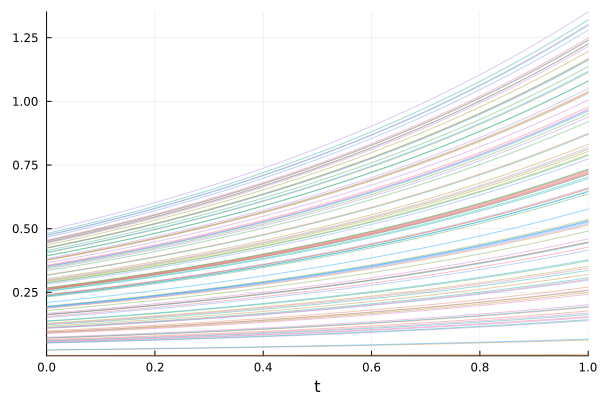

In [7]:
plot(sim, linealpha=0.4)

## Solving an SDE with Different Parameters

In [8]:
function lotka_volterra!(du, u, p, t)
    du[1] = p[1] * u[1] - p[2] * u[1] * u[2]
    du[2] = -3 * u[2] + u[1] * u[2]
end

function g!(du, u, p, t)
    du[1] = p[3] * u[1]
    du[2] = p[4] * u[2]
end

p = [1.5, 1.0, 0.1, 0.1]
prob = SDEProblem(lotka_volterra!, g!, [1.0, 1.0], (0.0, 10.0), p)

SDEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 10.0)
u0: 2-element Vector{Float64}:
 1.0
 1.0

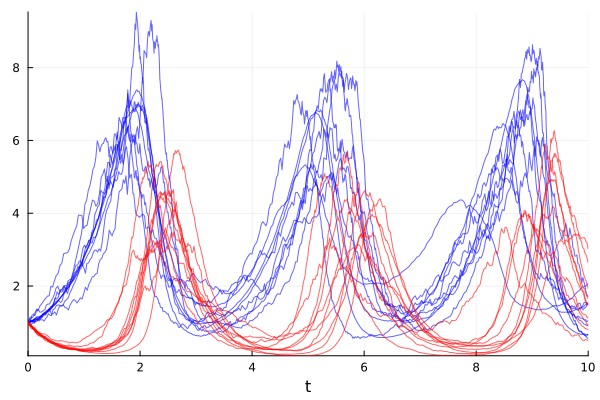

In [9]:
function prob_func(prob, i, repeat)
    x = 0.3 * rand(2)
    remake(prob, p=[p[1:2]; x])
end

ensemble_prob = EnsembleProblem(prob, prob_func=prob_func)
sim = solve(ensemble_prob, SRIW1(), trajectories=10)

fig = plot(sim, linealpha=0.6, color=:blue, idxs=(0, 1))
plot!(fig, sim, linealpha=0.6, color=:red, idxs=(0, 2))

Show the distribution of the ensemble solutions

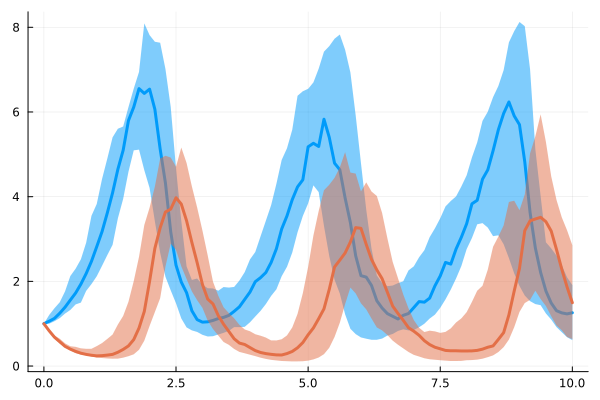

In [10]:
summ = EnsembleSummary(sim, 0:0.1:10)
plot(summ, fillalpha=0.5)

## Ensemble simulations of Modelingtoolkit (MTK) models
Radioactive decay example

In [11]:
using ModelingToolkit
using DifferentialEquations

@variables t c(t) = 1.0
@parameters λ = 1.0
D = Differential(t)
@mtkbuild sys = ODESystem([D(c) ~ -λ * c], t)
prob = ODEProblem(sys, [], (0.0, 2.0), [])

┌ Warning: Independent variable t should be defined with @independent_variables t.
└ @ ModelingToolkit ~/.julia/packages/ModelingToolkit/0O7FS/src/utils.jl:119


ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 2.0)
u0: 1-element Vector{Float64}:
 1.0

Use the symbolic interface to change the parameter(s).

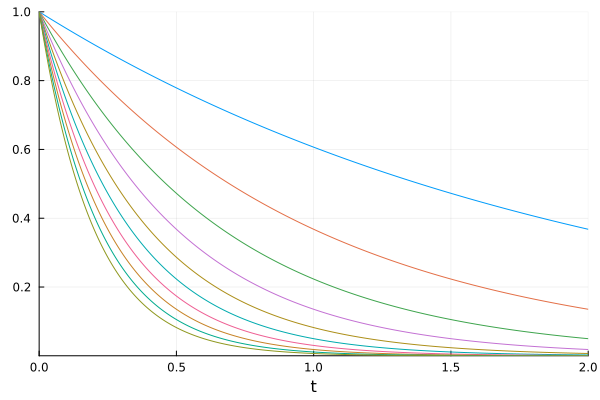

In [12]:
function changemtkparam(prob, i, repeat)
    # Make a new copy of the parameter vector
    # Ensure the changed will not affect the original ODE problem
    remake(prob, p=[λ => i * 0.5])
end

ensemble_prob = EnsembleProblem(prob, prob_func=changemtkparam)
sim = solve(ensemble_prob, trajectories=10)
plot(sim, fillalpha=0.5)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*